# Import libraries and data

**Introduction** This notebook has been developed for the Digit Recognizer Kaggle competition (https://www.kaggle.com/competitions/digit-recognizer). The objective is to predict numbers from images using computer vision techniques. To address this task, *Convolutional and Fully Connected Neural Networks* were employed. Furthermore, the model's performance was enhanced through the application of *Dropout* and *Batch Normalization* techniques. An accuracy of **0.99** was achieved.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
train_df = pd.read_csv (r'C:\Users\Dima\Downloads\train.csv.zip')
test_df = pd.read_csv (r'C:\Users\Dima\Downloads\test.csv.zip')
submission = pd.read_csv (r'C:\Users\Dima\Downloads\sample_submission.csv')

In [3]:
train_df.head ()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head ()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data analysis and data preproccessing

## Data analysis

In [5]:
train_df.shape

(42000, 785)

In [6]:
test_df.shape

(28000, 784)

In [7]:
# max value in df
max(train_df.max())

255

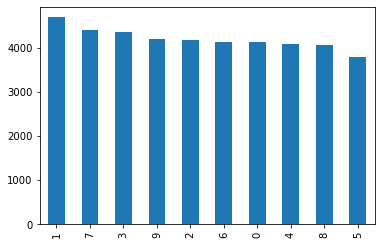

In [8]:
train_df.label.value_counts().plot(kind='bar')
plt.show()

Training dataset is balanced

## Split the data into training and validation set

Spliting the data in an 80:20 ratio

In [9]:
ratio = 42000*0.2 #The size of the dataset is multiplied by a ratio level
ratio = int (ratio)
ratio

8400

In [10]:
validation_df = train_df[:ratio]
validation_df.shape

(8400, 785)

In [11]:
train_df = train_df[ratio:]
train_df.shape

(33600, 785)

## Show first 20 images

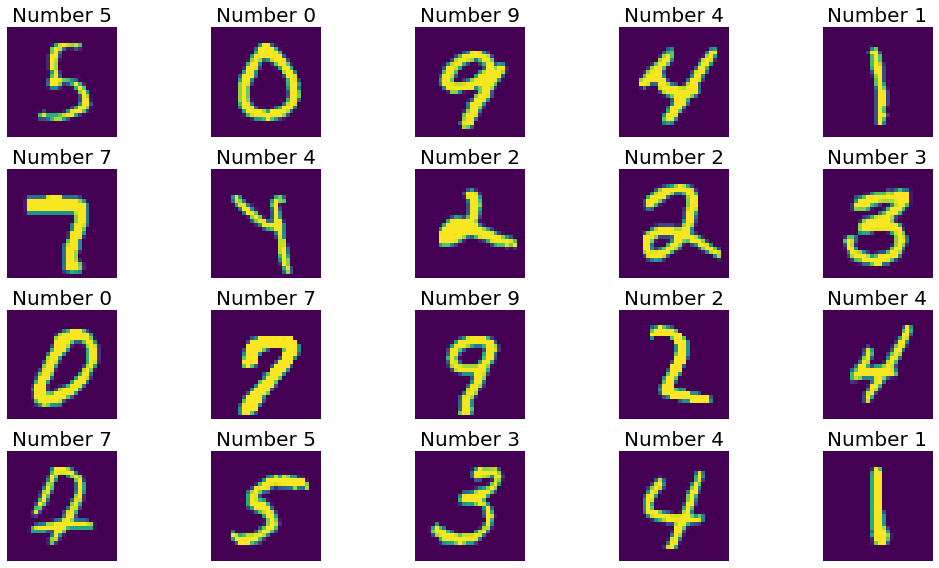

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(15, 8))
for j in range(4):
  for i in range(5):
    index = j * 5 + i
    pixels = train_df.iloc[index, 1:].values
    image = np.reshape(pixels, (28, 28))
    axes[j,i].imshow(image)
    axes[j,i].set_title(f"Number {train_df.iloc[index, 0]}", fontsize = 20)
    axes[j,i].axis('off')
plt.tight_layout()
plt.show()

**Conclusion:** Numbers are centered, but some of them are tilted. That's why it's necessary to use the 'rotation_range'. Additionally, there are some horizontal deviations.

## Data preproccesing

### Convert data into an array

In [45]:
# Convert train data into array
image_arrays = []
for index, row in train_df.iterrows():
    pixels = row.values[1:]  
    image_array = np.array(pixels).reshape(28, 28, 1)
    image_arrays.append(image_array)

images = np.array(image_arrays)

In [46]:
#Create and convert validation data labels 
labels = np.array(train_df.label)

In [47]:
# Convert validation data
image_arrays_val = []
for index, row in validation_df.iterrows():
    pixels_val = row.values[1:]  
    image_array_val = np.array(pixels_val).reshape(28, 28, 1)
    image_arrays_val.append(image_array_val)

images_val = np.array(image_arrays_val)

In [48]:
#Create and convert validation data labels 
labels_val = np.array(validation_df.label)

In [49]:
# Convert validation data
image_arrays = []
for index, row in test_df.iterrows():
    pixels = row.values[0:]
    image_array = np.array(pixels).reshape(28, 28, 1)
    image_arrays.append(image_array)

images_test = np.array(image_arrays)

### Data augmentation

In [50]:
train_datagen = ImageDataGenerator (rescale = 1./255,
                                    rotation_range = 15,
                                    width_shift_range = 0.05,
                                    height_shift_range = 0.05,
                                    shear_range = 0.05,
                                    fill_mode = 'nearest')

In [51]:
#Augmentaion train data
train_generator = train_datagen.flow (images,
                                      batch_size = 256,
                                      y=labels,
                                      )


In [52]:
validation_datagen = ImageDataGenerator (rescale = 1./255)

In [53]:
#Augmentaion validation data
validation_generator = validation_datagen.flow (images_val,
                                      batch_size = 256,
                                      y=labels_val          
                                      )

# Modeling

## Create model with validation and training dataset

In [82]:
# Create model
model = tf.keras.models.Sequential ([
    tf.keras.layers.Conv2D (48, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D (64, (5,5), activation = 'relu'),
    tf.keras.layers.Conv2D (64, (4,4), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense (24, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout (0.05),
    tf.keras.layers.Dense (10, activation = 'softmax')
  ])


In [83]:
model.compile (
    optimizer=tf.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
history = model.fit(train_generator, epochs = 100, validation_data = validation_generator)

Epoch 1/100
165/165 [==============================] - 55s 325ms/step - loss: 0.6124 - accuracy: 0.9044 - val_loss: 0.9700 - val_accuracy: 0.9664
Epoch 2/100
165/165 [==============================] - 56s 339ms/step - loss: 0.1971 - accuracy: 0.9756 - val_loss: 0.2432 - val_accuracy: 0.9886
Epoch 3/100
165/165 [==============================] - 54s 325ms/step - loss: 0.1206 - accuracy: 0.9811 - val_loss: 0.0978 - val_accuracy: 0.9857
Epoch 4/100
165/165 [==============================] - 57s 345ms/step - loss: 0.0942 - accuracy: 0.9839 - val_loss: 0.0685 - val_accuracy: 0.9896
Epoch 5/100
165/165 [==============================] - 60s 362ms/step - loss: 0.0814 - accuracy: 0.9855 - val_loss: 0.0649 - val_accuracy: 0.9876
Epoch 6/100
165/165 [==============================] - 60s 364ms/step - loss: 0.0729 - accuracy: 0.9869 - val_loss: 0.0546 - val_accuracy: 0.9910
Epoch 7/100
165/165 [==============================] - 60s 364ms/step - loss: 0.0668 - accuracy: 0.9881 - val_loss: 0.0629 -

Epoch 57/100
165/165 [==============================] - 80s 483ms/step - loss: 0.0221 - accuracy: 0.9966 - val_loss: 0.0212 - val_accuracy: 0.9973
Epoch 58/100
165/165 [==============================] - 82s 499ms/step - loss: 0.0235 - accuracy: 0.9965 - val_loss: 0.0239 - val_accuracy: 0.9965
Epoch 59/100
165/165 [==============================] - 80s 486ms/step - loss: 0.0255 - accuracy: 0.9960 - val_loss: 0.0262 - val_accuracy: 0.9961
Epoch 60/100
165/165 [==============================] - 81s 492ms/step - loss: 0.0248 - accuracy: 0.9962 - val_loss: 0.0229 - val_accuracy: 0.9964
Epoch 61/100
165/165 [==============================] - 83s 503ms/step - loss: 0.0248 - accuracy: 0.9962 - val_loss: 0.0163 - val_accuracy: 0.9982
Epoch 62/100
165/165 [==============================] - 76s 463ms/step - loss: 0.0283 - accuracy: 0.9957 - val_loss: 0.0226 - val_accuracy: 0.9971
Epoch 63/100
165/165 [==============================] - 79s 481ms/step - loss: 0.0234 - accuracy: 0.9967 - val_loss: 0

In [84]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, None, None, 48)    480       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, None, None, 48)    0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 64)    76864     
                                                                 
 conv2d_36 (Conv2D)          (None, None, None, 64)    65600     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, None, None, 64)    0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, None, None, 64)  

**Conclusion:** An accuracy of 0.99 was achieved. The attempt to enhance accuracy by adding additional epochs or incorporating new information from the validation dataset did not lead to further improvement.

# Prediction

In [85]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow(images_test, batch_size=128, shuffle=False)
predictions = model.predict(test_generator)
predicted_labels = predictions.argmax(axis=1)

219/219 [==============================] - 14s 62ms/step


In [86]:
predicted_labels

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [87]:
submission['Label'] = predicted_labels

In [88]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [89]:
submission.to_csv('submission.csv', index=False)